In [108]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

from utils_martina.my_utils import *

from changepoint_online import NPFocus

In [109]:
logs_path = "..\\..\\explainability\GRETEL-repo\\output\\logs\\"
eval_manager_path = "..\\..\\explainability\GRETEL-repo\\output\\eval_manager\\"
output_path = "..\\..\\explainability\GRETEL-repo\\output\\evolution_3d_embeddings\\"

In [110]:
file_name = get_most_recent_file(eval_manager_path).split('.')[0]
print(file_name)

12084-Martina


## Info

In [111]:
index_evaluator = 0

In [ ]:
# Set patient and record
patient_id = "chb01"
record_id = "04"

# ["chb01_03", "chb01_04", "chb01_15", "chb01_16", "chb01_18", "chb01_21", "chb01_26"]

frequency = 256

## Load data

In [114]:
# Load information related to the EEG of patient_id, record_id
with open(f"EEG_data\EEG_data_params_{patient_id}_{record_id}.pkl", "rb") as f:
    loaded_variables = pickle.load(f)

indices = loaded_variables["indici"]
Start = loaded_variables["Start"]
End = loaded_variables["End"]
seizure_starts = loaded_variables["seizure_starts"]
seizure_ends = loaded_variables["seizure_ends"]
seizure_class = loaded_variables["seizure_class"]

In [115]:
# Load logs
with open(logs_path + file_name + '.info', "r") as file:
    content = file.read()

# Load eval_manager
with open(eval_manager_path + file_name + '.pkl', 'rb') as f:
    eval_manager = pickle.load(f)

In [116]:
for i in range(len(eval_manager._evaluators)):
    if i == index_evaluator:
        print(f"---> {eval_manager._evaluators[i]._explainer.name}")
    else:
        print(f"     {eval_manager._evaluators[i]._explainer.name}")

---> DCESExplainer-3cbc0ed5617a269c1a6b2336dbadae85


In [117]:
# Function to plot vertical bands for seizure conditions
def add_seizure_shading(ax, starts, ends, also_horizontal=False):
    for start, end in zip(starts, ends):
        ax.axvspan(start, end, color='yellow', alpha=0.5)

        if also_horizontal:
            ax.axhspan(start, end, color='orange', alpha=0.5)

## Probabilities

In [160]:
import torch

prob = []
time = []

pairs = eval_manager._evaluators[0].get_instance_explanation_pairs()
for g1 in eval_manager._evaluators[0].dataset.instances:
    if g1.patient_id == patient_id and g1.record_id == record_id:
        logits = eval_manager._evaluators[0]._oracle.predict_proba(g1)
        prob.append(torch.softmax(logits, dim=0))
        time.append(indices[g1.time]/256 + Start)

prob = np.array(prob)

In [161]:
# Data
Y = prob[:np.where(time < np.min(seizure_starts))[0].max(),1]
Y = Y[::-1]
time = time[:np.where(time < np.min(seizure_starts))[0].max()]
time = time[::-1]

# Create and use NPFocus detector
## One needs to provide some quantiles to track the null distribuition over
quantiles = [np.quantile(Y[:100], q) for q in [0.25, 0.5, 0.75]]
## the detector can be initialised with those quantiles
detector = NPFocus(quantiles)

stat_over_time = []

for y in Y:
    detector.update(y)
    # we can sum the statistics over to get a detection
    # see  (Romano, Eckley, and Fearnhead 2024) for more details
    if np.sum(detector.statistic()) > 17:
        break

changepoint_info = detector.changepoint()

In [162]:
Y = Y[::-1]
time = time[::-1]
c = time[len(time) - changepoint_info["stopping_time"]]
print(c)

1028.59765625


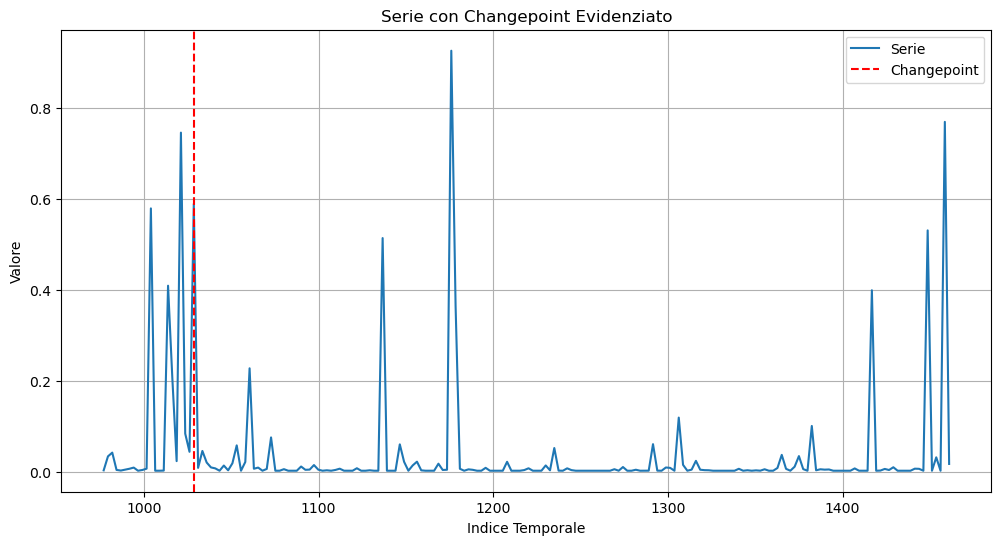

In [163]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(time, Y, label='Serie')
plt.axvline(x=c, color='r', linestyle='--', label='Changepoint')
plt.title('Serie con Changepoint Evidenziato')
plt.xlabel('Indice Temporale')
plt.ylabel('Valore')
plt.legend()
plt.grid(True)
plt.show()